# Overview

Major League Baseball(MLB) has been organizing and playing professional baseball since 1903 and will continue to do so for the foreseable future. With this many years and hundreds of thousands of games played there must be a way to predict who is going to win each game with a high degree of accuracy. With sports betting becoming more popular throughout the United States in the past 10 years due to legalization in many states, there is even more of a push to find a way to predict the outcome of these games. This project seeks to answer what factors lead to a team winning and also building a model that can predict the outcome.


# Business Case

The sports betting industry has been skyrocketing in value due to the addition of millions of participants in each state due to the legalization of sports betting. There are still many people who are hesitant to risk their money on something they believe to be a coin toss. This project seeks to help those who cannot afford to spend large amounts of time studying the game of baseball by providing an indication as to what team will be victorious. In turn this will get more people on betting sites and no matter the outcome, the betting organizations will increase profit due to the increase in bets.

# Data Collection / Creation

The dataset used in this project was created through the use of [retrosheet.org](https://www.retrosheet.org/) as it has one of the largest collection of MLB statistics and records from the past 100+ years of play. The collected statistics try and capture what happened in the game in terms of batting, fielding, and pitching and can give an indication as to why one team performed better than the other.

The dataset includes features about how each team perfomed in every game leading up to the game that we are predicting the outcome of. This inlcudes features on how that team has batted with statistics like batting average, on base percentage, and commonly recorded statistics like hits, singles, doubles, and many more. Pitching statistics are also being used such as earned runs average, number of pitchers used, and strikeouts. Lastly, fielding statsistics like putouts, assists, and passed balls are used round out the last aspect of the game.

First we must create the normal game-by-game data frame. Each row will be the statistics of the home and away team.

In [1]:
# imports used to manipulate data and describe the data with plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# these are the columns of the data frame
# these are year-spanning stats
from dataframe_creation import get_pbp_columns
columns = get_pbp_columns()
# all years that the data is from
years = list(range(2000,2020))

In [3]:
# importing the data from each file
# the files are done year by year
df = pd.DataFrame()
for year in years:
    url = 'data/retro_data/year_games/GL{}.txt'.format(year)
    temp = pd.read_csv(url)
    temp.columns = columns
    df = df.append(temp)

Some teams in the past 20 years have swtiched their name so the tag changed. Here are those changes:
* Florida Marlins (FLO) -> Miami Marlins (MIA)
* Montreal Expos (MON) -> Washinton Nationals (WAS)

In [4]:
# changing those team names
df = df.applymap(lambda x: "WAS" if x=='MON'else ('MIA' if x=='FLO' else x))

Now that we have our base data set we are going to create some new features that seek to capture more information on the game.

From this we can see that the aggregate data performs better than the normal per game statistics data. The reason for this improvement is each team is not being assesed on only their previous game but all previous games that season. A team is not how well they did last game but how well they have been doing that season. One off game can throw off predictions. Logistic regression and XGBoost are going to be futher improved due to their accuracy in these intial tests.

# Feature Engineering

Since the start of baseball, statisticians have been trying to create statistics that capture more information on what is happening in the game than the standard ones. A revolutionary set of statistics created by the [Society for American Baseball Research](https://sabr.org/sabermetrics) (SABR), known as sabermetrics, have been the most impactful to the understanding of baseball. These include weighted on base percentage, fielding independent pitching, batting average on balls in play, and many more. I will be creating some of these in this section.

In [5]:
# converting to date time
df.Date = pd.to_datetime(df.Date,format='%Y%m%d')
# creating a game id that can be used for indetification of each game
df['id'] = df['home_team']+df.Date.dt.year.astype('str') + df.Date.dt.month.astype('str') + df.Date.dt.day.astype('str')
# creating year column for grouping
df['year'] = df.Date.map(lambda x: x.year)
# outcome of game in terms of home team  loosing (0) or winning (1)
# have to change score to int
df.home_team_score.astype('int')
df.away_team_score.astype('int')
cond = [
    df.home_team_score > df.away_team_score,
    df.away_team_score > df.home_team_score
]
outcome = [
    1, # home wins
    0  # away wins
]
df['home_outcome'] = np.select(cond,outcome,default = -1)
# outcome of game in terms of away team  loosing (0) or winning (1)
cond = [
    df.away_team_score > df.home_team_score, # away wins
    df.home_team_score > df.away_team_score  # home wins
]
outcome = [
    1, # away wins
    0  # home wins
]
df['away_outcome'] = np.select(cond,outcome,default = -1)
# OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies)
df['home_OBP'] = (df.home_hits + df.home_walk + df.home_hbp) / (df.home_at_bats + df.home_walk + df.home_hbp + df.home_sf)
df['away_OBP'] = (df.away_hits + df.away_walk + df.away_hbp) / (df.away_at_bats + df.away_walk + df.away_hbp + df.away_sf)
# AVG = hits / at bats
df['home_AVG'] = df.home_hits / df.home_at_bats
df['away_AVG'] = df.away_hits / df.away_at_bats
# singles = hits - (doubles + triples + hr)
df['home_singles'] = df.home_hits - (df.home_doubles + df.home_triples + df.home_hrs)
df['away_singles'] = df.away_hits - (df.away_doubles + df.away_triples + df.away_hrs)
# SLG = singles + 2 x doubles (2B) + 3 x triples (3B) + 4 x home runs (HR) / AB
df['home_SLG'] = (df.home_singles + 2*df.home_doubles + 3*df.home_triples + 4*df.home_hrs) / df.home_at_bats
df['away_SLG'] = (df.away_singles + 2*df.away_doubles + 3*df.away_triples + 4*df.away_hrs) / df.away_at_bats
# BABIP = (H - HR)/(AB - K - HR + SF)
df['home_BABIP'] = (df.home_hits - df.home_hrs) / (df.home_at_bats - df.home_so - df.home_hrs + df.home_sf)
df['away_BABIP'] = (df.away_hits - df.away_hrs) / (df.away_at_bats - df.away_so - df.away_hrs + df.away_sf)
# ISO = (1x2B + 2x3B + 3xHR) / At-bats OR Slugging percentage - Batting average
df['home_ISO'] = df.home_SLG - df.home_AVG
df['away_ISO'] = df.away_SLG - df.away_AVG
# PA/SO = total plate appearances by his number of strikeouts
df['home_PASO'] = df.home_at_bats / df.home_so
df['away_PASO'] = df.away_at_bats / df.away_so
# TB = 1x1B + 2x2B + 3x3B + 4x4B
df['home_total_bases'] = df.home_singles + (2*df.home_doubles) + (3*df.home_triples) + (4*df.home_hrs)
df['away_total_bases'] = df.away_singles + (2*df.away_doubles) + (3*df.away_triples) + (4*df.away_hrs)
# RC = (TB x (H + BB)) / (AB + BB)
df['home_runs_created'] = ( df.home_total_bases * (df.home_hits + df.home_walk)) / (df.home_at_bats + df.home_walk)
df['away_runs_created'] = ( df.away_total_bases * (df.away_hits + df.away_walk)) / (df.away_at_bats + df.away_walk)
# wOBA = 0.69 x NIzBB + 0.72 x HBP + 0.89. x 1B + 1.27 x 2B + 1.62 x 3B + 2.10 x HR / AB + BB - IBB + SF + HBP
df['home_wOBA'] = ((0.69*df.home_walk)+(0.72 * df.home_hbp) + (0.89 * df.home_singles) + (1.27 * df.home_doubles) + (1.62 * df.home_triples) + (2.10 * df.home_hrs)) / (df.home_at_bats+df.home_walk - df.home_int_walk + df.home_sf + df.home_hbp)
df['away_wOBA'] = ((0.69*df.away_walk)+(0.72 * df.away_hbp) + (0.89 * df.away_singles) + (1.27 * df.away_doubles) + (1.62 * df.away_triples) + (2.10 * df.away_hrs)) / (df.away_at_bats+df.away_walk - df.away_int_walk + df.away_sf + df.away_hbp)

#### Game Number of that Season
It is important to assign what game number that is for that season as the cumulative stats (that will be created later) should only be used after the first couple games (will be using games after the first 10). All the code for these functions can be found in `feature_engineering.ipynb`.

In [6]:
# creating an empty dictionary so that the games of each team can be split by year
test_dict = {}
# all years that the data is from
year_list = list(range(2000,2020,1))
team_list = df.home_team.unique()
for year in year_list:
    test_dict[year] = {}
    for team in team_list:
        test_dict[year][team] = []

In [7]:
# inserting games into the correct container
# sorted by year the team
for index,row in df.iterrows():
    test_dict[row.year][row.home_team].append(row.id)

In [8]:
game_number_list = []
# iterating through each year/team and assigning the game number (1-81)
for year in test_dict:
    for team in test_dict[year]:
        counter=1
        for game in test_dict[year][team]:
            game_number_list.append([game,counter])
            #df[(df.id == game)]['game_number_of_season'] = counter
            #print(df[(df.id == game)]['game_number_of_season'],end=' ')
            counter+=1
add_on_df = pd.DataFrame(game_number_list,columns=['id','game_number_of_season'])
df = df.merge(add_on_df,how='left',on='id')

In [9]:
from dataframe_creation import create_home_won_prev, create_away_won_prev
df['home_won_last_game'] = create_home_won_prev(df)
df['away_won_last_game'] = create_home_won_prev(df)

In order to capture how a team is doing up until that point in the year the data must be aggregated so that every row describes how that team has performed up until that point.

In [10]:
from dataframe_creation import create_win_next_game
df['target'] = create_win_next_game(df)

#### What are the aggregated statistics
The way that the aggregated stats are calculated are completelty different than the stats of the normal non-aggregated table. For aggregated stats the varibales are the average of the teams statistics up until that game and not including that current game. This allows us not to have to predict the outcome of the next game (the next game the home team plays) but the outcome of the game in that row. There is no data leakage because the stats from that game have not yet been added to the aggregated stats therefore it is not included in the teams average up until that game.

In [11]:
# used for attaching to aggregate data later on
df_copy_for_attaching = df[['Date','home_team','away_team','home_outcome','away_outcome','game_number_of_season']]

In [12]:
from dataframe_creation import create_aggregate_data
df_agg = df.copy(deep=True)
df_agg = create_aggregate_data(df_agg)

# Exploratory Data Analysis

#### Data Understanding
The dataset used in this project was created through the use of [retrosheet.org](https://www.retrosheet.org/) as it has one of the largest collection of MLB statistics and records from the past 100+ years of play. The collected statistics try and capture what happened in the game in terms of batting, fielding, and pitching and can give an indication as to why one team performed better than the other. Code for these images can be found in [exploratory_data_analysis.ipynb](./exploratory_data_analysis.ipynb)

![img](./images/num_runs_won_by.png)
Almost 30% of all games played are won by 1 run meaning the margin of victory is very small. This is one of the reasons that predicting the outcome of games is so hard due to one bad pitch leading to a home run can mean a loss for the defensive team.

![img](./images/home_vs_away.png)
The home team wins slightly more than the away team over all games played in the past 20 years. Over 50,000 games this is very important to consider but can be summed up to a team that does not need to travel and is front of their home crowd is more likely to win.

![img](./images/runs_per_year.png)
From this we can see that the scoring has generally been the same for the past 20 years. The difference between the highest scoring year and the lowest is about 5000 runs. In an article written in the New York Times (Now Pitchers Have the Power) they talk about how data was used to increase a teams ability to limit the amount of points scored.

![img](./images/hit_diff.png)
Teams who can generate more hits on average are much more likely to win the game. This makes sense as the more players you get on base the more players can be in scoring postion.

![img](./images/obp_diff.png)
From this scatter plot we can see that with the smallest advantage in OBP a team is much more likely to win. The reason for this is that the more people you can get on base the better chance of scoring.

Everything discussed in this section was created in `exploratory_data_analysis.ipynb`.

# Modeling

### Game to game stats

In [13]:
cols_to_drop = ['forfeit_info','lf_ump_id','rf_ump_id','protest_info',
                'date_game_completed','additional_info','save_pitch_id',
                'game_win_rbi_batter_id','game_in_series','away_catch_interference',
                'home_catch_interference','away_pitch_balks',
                'home_pitch_balks','day_of_week','away_league',
                'away_team_game_number','home_league',
                'home_team_game_number','day_or_night','park_id',
                'attendance','time_of_game','away_line_scores',
                'home_line_scores','year','id',
               'Date','away_team','home_team','game_number_of_season']
df.drop(columns=cols_to_drop,inplace=True)
df.drop(df.loc[:,'hb_ump_id':'acquisition_info'],axis=1,inplace=True)


In [14]:
# PASO has some infinite values and those rows are dropped
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df.dropna(inplace=True)

In [15]:
# creating x and y
X_norm = df.drop(columns='target')
y_norm = df.target

`baseline_prediction` will run inputed X and y data on a base model of logistic regression, decision tree, random forest, and XGBoost.

In [16]:
from baseline_model import baseline_prediction

In [17]:
baseline_prediction(X_norm,y_norm)

Logistic Regression Accuracy
Train=0.537 Test=0.533
Decision Tree Accuracy
Train=0.644 Test=0.525
Random Forest Accuracy
Train=1.0 Test=0.524
XGBoost Accuracy
Train=0.566 Test=0.537


The game by game statistics (only using the last game to predict the next game) performs pretty well. Logistic regression perfoms the best and overfitting is very very low. Decision tree and random forest overfit a ton with very poor results on test. XG boost overfits slightly and performs the same as random forst. Will be doing more testing on logistic regression.

### Aggregate stats

In [18]:
# changing the name of these becuase we already have the teams win % as this
df_copy_for_attaching.rename(columns={'home_outcome':'home_outcome_nonagg','away_outcome':'away_outcome_nonagg'},inplace=True)
# merging to df
df_agg = df_agg.merge(df_copy_for_attaching,how='left',on=['Date','home_team','away_team'])
# taking out the first 10 games due to them not having enough data
df_agg_cutt_early = df_agg[(df_agg.game_number_of_season > 10)]

In [19]:
# dropping columns no longer needed
cols_to_drop_agg_cutt = ['home_team','away_team','Date','away_outcome_nonagg','game_number_of_season']
df_agg_cutt_early.drop(columns=cols_to_drop_agg_cutt,inplace=True)
# PA/SO can result in infinite value, row dropped
df_agg_cutt_early.replace([np.inf,-np.inf],np.nan,inplace=True)
df_agg_cutt_early.dropna(inplace=True)

In [20]:
# target is the outcome of current game
X_agg_cutt = df_agg_cutt_early.drop(columns='home_outcome_nonagg')
y_agg_cutt = df_agg_cutt_early.home_outcome_nonagg

In [21]:
# baseline testing
baseline_prediction(X_agg_cutt,y_agg_cutt)

Logistic Regression Accuracy
Train=0.568 Test=0.561
Decision Tree Accuracy
Train=0.788 Test=0.55
Random Forest Accuracy
Train=0.967 Test=0.546
XGBoost Accuracy
Train=0.62 Test=0.579


From this we can see that the aggregate data performs better than the normal per game statistics data. The reason for this improvement is each team is not being assesed on only their previous game but all previous games that season. A team is not how well they did last game but how well they have been doing that season. One off game can throw off predictions. Logistic regression and XGBoost are going to be futher improved due to their accuracy in these intial tests.

## Feature Selection

Feature selection can be very useful by reducing the amount of features used in the model while also maintaining/increasing the accuracy score. A filter method of select k-best is going to be used first and then a wrapper method of recursive feature elimination after.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=99)

#### Filter Method

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

In [24]:
# instantiating a feature selector object
feature_selector = SelectKBest(f_classif,50)
# fitting to our data
feature_selector.fit(X_train,y_train)
# features that we keep
selected_filter = X_train.columns[feature_selector.get_support()]

In [25]:
baseline_prediction(X_agg_cutt[selected_filter],y_agg_cutt)

Logistic Regression Accuracy
Train=0.568 Test=0.559
Decision Tree Accuracy
Train=0.78 Test=0.545
Random Forest Accuracy
Train=0.967 Test=0.549
XGBoost Accuracy
Train=0.618 Test=0.577


#### Wrapper Method

In [26]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=99)
# we are going to use logistic regression as an estimator as it was the best performer in baseline tests
estimator = LogisticRegression()
# instantiate the wrapper method
feature_selector = RFECV(estimator=estimator, step=1, cv=10,n_jobs=-1)
# fit to train data
feature_selector.fit(X_train,y_train)
# get the selected features
selected_wrapper = X_train.columns[feature_selector.support_]
print('# of feature pre feature selection: {}'.format(len(X_train.columns)))
print('# of feature post feature selection: {}'.format(len(selected_wrapper)))

# of feature pre feature selection: 76
# of feature post feature selection: 65


In [28]:
baseline_prediction(X_agg_cutt[selected_wrapper],y_agg_cutt)

Logistic Regression Accuracy
Train=0.57 Test=0.56
Decision Tree Accuracy
Train=0.793 Test=0.553
Random Forest Accuracy
Train=0.967 Test=0.543
XGBoost Accuracy
Train=0.622 Test=0.581


The recursive feature elimination produces slightly better results than the filter method. This shows that using 16 less features only decresed prediction accuracy by 0.001 for logistic regression and 0.003 for XGBoost. I am going to continue with the full dataset as computation time is not an issure in this project. I also believe that allowing as much information into the models will aloow for the highest accuracy as much as posssible.

## Grid Searching Top Models

Grid searching will allow the model to iteratively try multiple parameters to find the set that predicts with the highest accuracy. As this process takes a significant amount of time (~5 mins for logistic regression and ~2 hours for XGBoost) I will be including a model with the optimal parameters.

### Logistic Regression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=99)

In [30]:
from sklearn.metrics import accuracy_score
lr_model = LogisticRegression(penalty='l2',C=1e9,max_iter=80)
lr_model.fit(X_train,y_train)
lr_model_predictions_train = lr_model.predict(X_train)
lr_model_predictions_test = lr_model.predict(X_test)
train_acc = accuracy_score(y_train, lr_model_predictions_train)
test_acc = accuracy_score(y_test, lr_model_predictions_test)
print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))

Train Accuracy: 0.571652
Test Accuracy: 0.562605


From testing different sets of parameters on this problem, a high regularization score is favorable. L2 is the best performing penalty. Max iterations seems to converge to 80. All of these have the same score but will end with 80 as it has the least iterations but also the same score.

From this we can see the the best logistic regression achieved a score of 57%. This is very good as it is 7% above being completely random which can help inform what team to choose.

#### Feature Importances
Logistic regression assings weights to every feature and this is how it makes predictions upon on input. The feature values of that input are then used in a linear combination with the weights to obtain a score. If this score is above a certain threshold it predicts 0 and if below that threshold it predicts 0.

In [31]:
feature_importance = lr_model.coef_[0]
features = X_agg_cutt.columns
feature_importance_list = []
for feature, importance in zip(features,feature_importance):
    feature_importance_list.append((feature,importance))
feature_importance_list.sort(key=lambda x: np.abs(x[1]),reverse=True)

In [32]:
feature_importance_list[0:20]

[('away_at_bats', -0.042932651416449044),
 ('home_at_bats', -0.04237245272877803),
 ('away_def_putouts', -0.034669956892419765),
 ('home_def_putouts', -0.030706985476755714),
 ('home_total_bases', -0.0178351950488524),
 ('away_so', -0.015031918276458856),
 ('away_total_bases', -0.013366154979250056),
 ('home_so', -0.013120212661408089),
 ('away_def_assists', -0.011851141173646213),
 ('home_hits', -0.010241304850402382),
 ('home_pitch_earned_runs', -0.009770194692083681),
 ('home_team_earned_runs', -0.009736667372730887),
 ('away_hits', -0.009588473721013516),
 ('home_left_on_base', -0.008166189862549902),
 ('home_def_assists', -0.007193485044776852),
 ('away_pitchers_used', -0.007126374764247533),
 ('away_pitch_earned_runs', -0.007117088041349978),
 ('away_team_earned_runs', -0.0071150704605775815),
 ('away_left_on_base', -0.00699651941302843),
 ('away_singles', -0.0068930883161643025)]

### XGBoost
Grid Seach of XGBoost will hopefully allow for good predictions as well as easily obtain feature importances.

In [33]:
import xgboost as xgb

In [34]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',
                                 learning_rate = 0.01,
                                 max_depth = 5,
                                 min_child_weight = 2,
                                 n_estimators = 300)
xgb_model.fit(X_train,y_train)

XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=2,
              n_estimators=300, objective='multi:softprob')

In [35]:
xgb_model_predictions_train = xgb_model.predict(X_train)
xgb_model_predictions_test = xgb_model.predict(X_test)
train_acc = accuracy_score(y_train, xgb_model_predictions_train)
test_acc = accuracy_score(y_test, xgb_model_predictions_test)
print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))

Train Accuracy: 0.639799
Test Accuracy: 0.582746


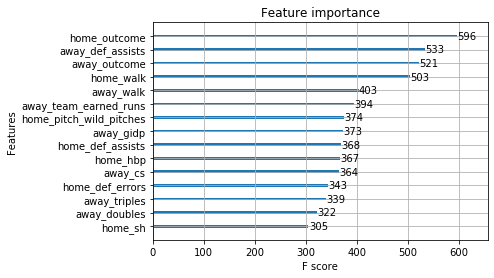

In [37]:
xgb.plot_importance(xgb_model,max_num_features = 15)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

From these feature importances we can see that the record of a team really impacts the outcome of the game. We can also see that the more walks a team is awarded the more likely they are to win the game. Away pitch earned runs means that a more a pitcher gives up runs the more likely we are to win which makes sense. I am assuming that a lot of these say that the less an opposing team perfoms the less they are able to win the game.

# Conclusion

- The record of each team (home and away) play a major part in the outcome of the game as teams who are winning
	
- The higher rate of assists and putouts by the defense limits the scoring potential of each team
	
- Walks lead to free base runners which increase chance of scoring greatly
	
- Going up against pitchers with low earned runs decreases chance of winning
	
- Wild pitches lead to movement of baserunners and put base runners in scoring position

These are just a couple takeaways from feature importances from the models. One thing to note is that there is no one statistic that can be used to make a large part of a prediction. It is the combination of many stats and how they differ from your opponent.

With this information it can help anyone who was on the edge of whether they would put their own money on the line. With a nudge in the right direction they will seek to almost always make a profit.

In [38]:
df_agg.to_csv('agg_data_final.csv')

In [39]:
df.to_csv('norm_data_final.csv')